# Study of [EPIC247418783](https://exofop.ipac.caltech.edu/k2/edit_target.php?id=247418783)

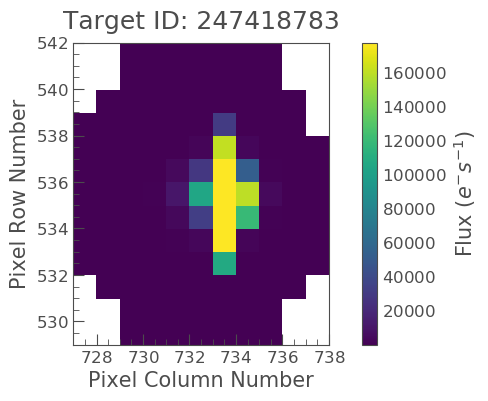

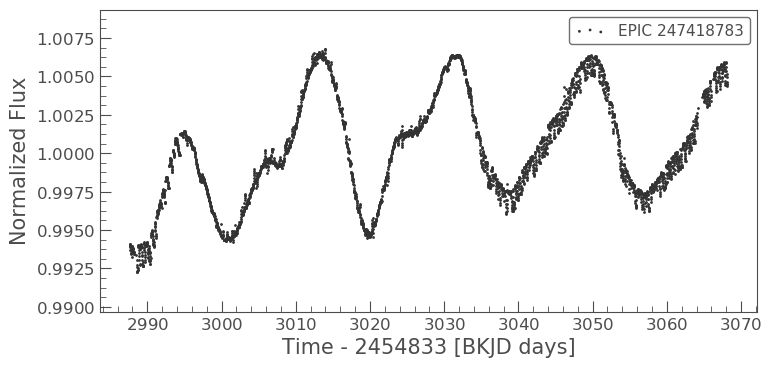

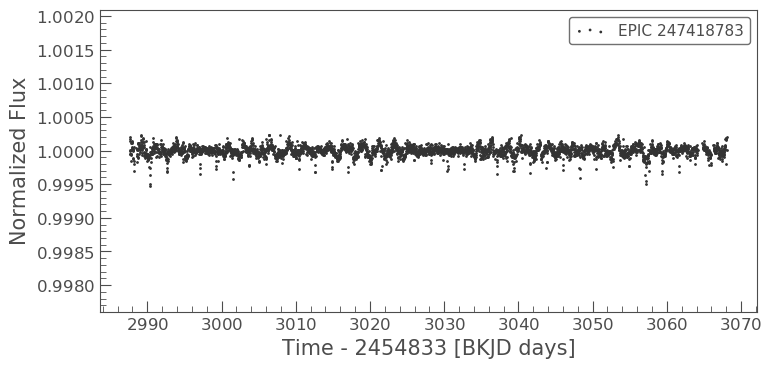

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '247418783'

tpf = search_targetpixelfile(target).download()
tpf.plot()
lc = search_lightcurvefile(target).download().PDCSAP_FLUX.remove_nans()
lc.scatter()
corr_lc = lc.to_corrector("sff").correct(windows=40)
corr_lc_f, trend = corr_lc.flatten(window_length=401, return_trend=True)
corr_lc_f = corr_lc_f.remove_outliers(sigma_lower=50,sigma_upper=3)
corr_lc_f.scatter()

Best Fit Period: 8.9015 days


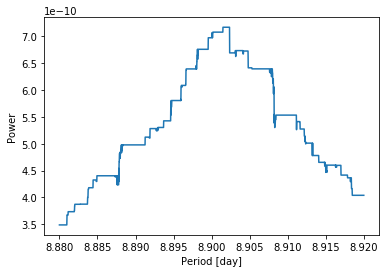

In [3]:
from astropy.stats import BoxLeastSquares
import matplotlib.pyplot as plt

bls = BoxLeastSquares(corr_lc_f.time, corr_lc_f.flux, corr_lc_f.flux_err)
periods = np.arange(8.88, 8.92, 0.00001)
durations = np.arange(0.005, 0.15, 0.001)
periodogram = bls.power(periods, durations)

plt.plot(periodogram.period, periodogram.power)
plt.ylabel("Power")
plt.xlabel("Period [day]");

period_p = periods[np.argmax(periodogram.power)]
print('Best Fit Period: {:0.4f} days'.format(period_p))

2.2253874999997962

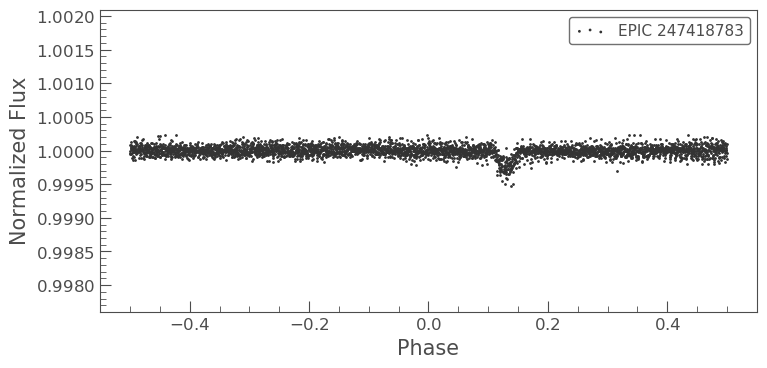

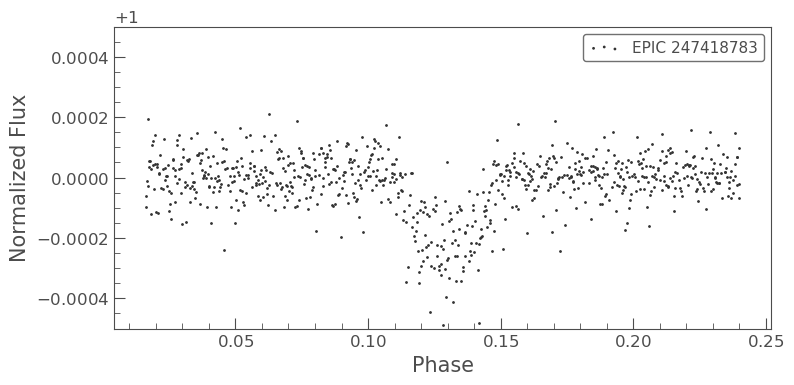

In [11]:
period_f = period_p / 4
lcf = corr_lc_f.fold(period=period_f,t0=1.4)
lcf.scatter()
lc_transit = lcf[1900:2700]
ax = lc_transit.scatter()
ax.set_ylim(0.9995,1.0005)
ax.plot()
lcf.time_format = 'jd'
period_f

In [5]:
import math

R_star = 1.039 # in sun's radius
R_star = R_star * 695510000 # in meter

Td_values = lc_transit.time[lc_transit.flux < 0.9998]
Td = 0.02

min_tr = lc_transit.flux[lc_transit.flux < 0.9998].mean()
R_planet = math.sqrt(1-min_tr)*R_star
R_planet = R_planet / R_star # in jupiter's radius

Td , R_planet

(0.02, 0.017066741265354228)

In [6]:
G = 6.67408 * 10**(-11)
P = period_f*86400
M = 0.971*1.98847*10**30
a = (G*M*P**2/(2*math.pi)**2) ** (1./3)
i = math.acos(math.sqrt((R_star/a)**2 - (Td*math.pi/P)**2)) # in radians
b = a * math.cos(i)

a = a / R_star # astronomical unit
b = b / R_star
i = math.degrees(i)

a, i, b

(6.838339315085854, 81.59123669075406, 0.9999999999975038)

In [47]:
u1 = 0.30495
u2 = 0.3095
µ = math.cos(math.asin(b))

I_µ = 1 - u1*(1-µ) - u2*((1-µ)**2)

I_µ, µ

(0.38555412936241185, 4.469255472640823e-06)

In [48]:
R_planet = R_planet * 69911000
R_planet = math.sqrt((1-min(lc_transit.flux))/I_µ)*R_star
R_planet = R_planet / 69911000

R_planet*11.2

4.315377407944666

## With batman:

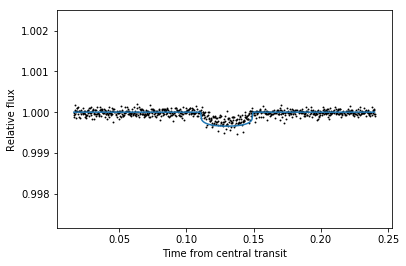

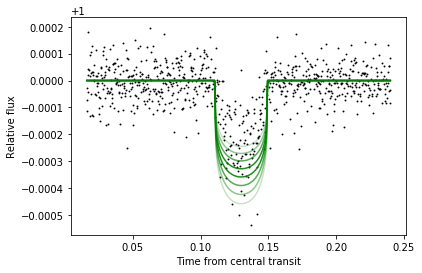

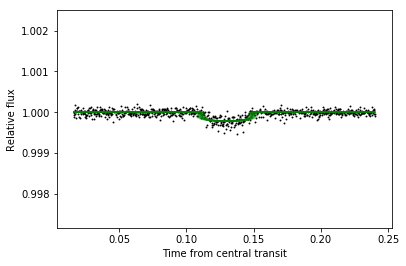

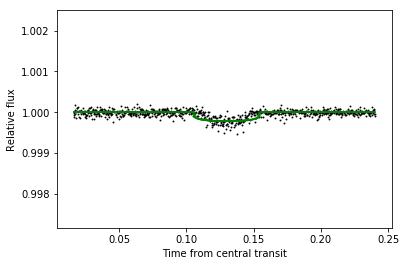

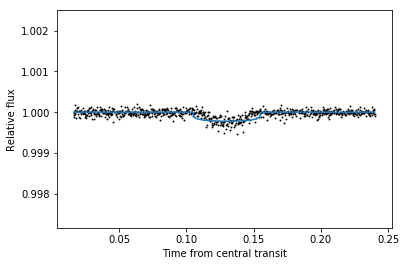

Planet's radius: 0.13240004283530799 [Jupiter radius]
Planet's semi-major axis: 0.029775824879224012 [AU]
Planet's semi-major axis: 86.24 [degrees]


In [12]:
import batman

params = batman.TransitParams()
params.t0 = 0.13                     #time of inferior conjunction
params.per = abs(lcf[-1].phase - lcf[0].phase)                      #orbital period
params.rp = 0.017                      #planet radius (in units of stellar radii)
params.a = 8                     #semi-major axis (in units of stellar radii)
params.inc = 88                   #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity
params.w = 90.                       #longitude of periastron (in degrees)
params.u = [0.3762, 0.27185]                #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"

t = np.linspace(lc_transit[0].phase, lc_transit[-1].phase, len(lc_transit.flux))    #where the transit is

m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)  #calculates light curve

plt.scatter(lc_transit.time, lc_transit.flux, s=.8, c='k')
plt.plot(t, flux)
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()

#RADIUS

rp_min = params.rp-0.2*params.rp
rp_max = params.rp+0.2*params.rp
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
radii = np.linspace(rp_min, rp_max, 10)
possible_radii = []
for r in radii:
        params.rp = r                           #updates planet radius
        new_flux = m.light_curve(params)
        plt.plot(t, new_flux, alpha = 1 - abs(r - ((rp_max+rp_min)/2))/((rp_max-rp_min)/2), color='green')
        diff = 0
        count = 0
        for f in new_flux:
            diff += abs(lc_transit.flux[count]-f)
            count += 1
        possible_radii.append([r,diff])

        
plt.scatter(lc_transit.time, lc_transit.flux, s=.8, c='k')
plt.show()
pos_min = 0
for i in range(0,len(possible_radii)-1):
    if (possible_radii[i][1]<possible_radii[i+1][1] and possible_radii[i][1]<possible_radii[pos_min][1]):
        pos_min = i
        
params.rp = possible_radii[pos_min][0]

#SEMI-MAJOR AXIS

a_min = params.a - 0.2*params.a
a_max = params.a + 0.2*params.a
plt.scatter(lc_transit.time, lc_transit.flux, s=.8, c='k')
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
axis = np.linspace(a_min, a_max, 10)
possible_axis = []
for a in axis:
        params.a = a                           #updates planet semi-major axis
        new_flux = m.light_curve(params)
        plt.plot(t, new_flux, alpha = 1 - abs(a - ((a_max+a_min)/2))/((a_max-a_min)/2), color='green')
        diff = 0
        count = 0
        for f in new_flux:
            diff += abs(lc_transit.flux[count]-f)
            count += 1
        possible_axis.append([a,diff])

plt.show()
pos_min = 0
for i in range(0,len(possible_axis)-1):
    if (possible_axis[i][1]<possible_axis[i+1][1] and possible_axis[i][1]<possible_axis[pos_min][1]):
        pos_min = i

params.a = possible_axis[pos_min][0]

#INCLINATION

i_min = params.inc - 0.02*params.inc
i_max = params.inc + 0.02*params.inc
plt.scatter(lc_transit.time, lc_transit.flux, s=.8, c='k')
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
incl = np.linspace(i_min, i_max, 10)
possible_inc = []
for i in incl:
        params.inc = i                           #updates planet semi-major axis
        new_flux = m.light_curve(params)
        plt.plot(t, new_flux, alpha = 1 - abs(i - ((i_max+i_min)/2))/((i_max-i_min)/2), color='green')
        diff = 0
        count = 0
        for f in new_flux:
            diff += abs(lc_transit.flux[count]-f)
            count += 1
        possible_inc.append([i,diff])

plt.show()
pos_min = 0
for i in range(0,len(possible_inc)-1):
    if (possible_inc[i][1]<possible_inc[i+1][1] and possible_inc[i][1]<possible_inc[pos_min][1]):
        pos_min = i

params.i = possible_inc[pos_min][0]

m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)  #calculates light curve

plt.scatter(lc_transit.time, lc_transit.flux, s=.8, c='k')
plt.plot(t, flux)
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()

print("Planet's radius: " + str(possible_radii[pos_min][0]/0.102719) + " [Jupiter radius]")
print("Planet's semi-major axis: " + str(possible_axis[pos_min][0]/214.93946938362) + " [AU]")
print("Planet's semi-major axis: " + str(possible_inc[pos_min][0]) + " [degrees]")